### Jorge P. Rodríguez, 2023
This notebook can be executed in Ocean Data Connector (Hub Ocean)

In [1]:
import pandas as pd
import geopandas as gp
import pylab as plt
import numpy as np
plt.style.use('classic')
import matplotlib.colors as colors
import matplotlib.colorbar as chi
import math

In [2]:
import odp.geospatial as odp

In [3]:
gd=odp.GridData()

In [4]:
ds=gd.open_dataset('Vessel Traffic and CO2 Emissions')
ds

,Array,Chunk
Bytes,6.79 GiB,7.63 MiB
Shape,"(28, 3972, 8194)","(1, 1000, 1000)"
Count,1009 Tasks,1008 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,6.79 GiB,7.63 MiB
Shape,"(28, 3972, 8194)","(1, 1000, 1000)"
Count,1009 Tasks,1008 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [5]:
del gd

In [6]:
#let's focus on Arctic and on total
ds_arctic = ds.sel(lat=slice(66.4,90.0),time=slice('2019-01-01','2022-12-31')
                ).hours_total.compute()
del ds

In [7]:
clat = []
for lat in ds_arctic.lat.values:
    clat.append(int(10*(lat-66.4)))
clon = []
for lon in ds_arctic.lon.values:
    clon.append(int(10*(180+lon)))
print(len(clat),len(clon))

538 8194


In [8]:
utimes = list(ds_arctic.time.values)
utimes.sort()
print(utimes,len(utimes))

[numpy.datetime64('2020-01-01T00:00:00.000000000'), numpy.datetime64('2020-02-01T00:00:00.000000000'), numpy.datetime64('2020-03-01T00:00:00.000000000'), numpy.datetime64('2020-04-01T00:00:00.000000000'), numpy.datetime64('2020-05-01T00:00:00.000000000'), numpy.datetime64('2020-06-01T00:00:00.000000000'), numpy.datetime64('2020-07-01T00:00:00.000000000'), numpy.datetime64('2020-08-01T00:00:00.000000000'), numpy.datetime64('2020-09-01T00:00:00.000000000'), numpy.datetime64('2020-10-01T00:00:00.000000000'), numpy.datetime64('2020-11-01T00:00:00.000000000'), numpy.datetime64('2020-12-01T00:00:00.000000000'), numpy.datetime64('2021-01-01T00:00:00.000000000'), numpy.datetime64('2021-02-01T00:00:00.000000000'), numpy.datetime64('2021-03-01T00:00:00.000000000'), numpy.datetime64('2021-04-01T00:00:00.000000000'), numpy.datetime64('2021-05-01T00:00:00.000000000'), numpy.datetime64('2021-06-01T00:00:00.000000000'), numpy.datetime64('2021-07-01T00:00:00.000000000'), numpy.datetime64('2021-08-01T0

In [9]:
Nlat = len(clat)
Nlon = len(clon)

In [10]:
cell = []
for i in range(Nlat):
    ct = []
    for j in range(Nlon):
        c = clon[j]+10*360*clat[i]
        ct.append(c)
    cell.append(ct)
del ct

In [21]:
R = 6371.
pi = np.pi
areas = []
for i in range(360*10*int(10*(90-66.4)+1)):
    cy = int(i/(10*360))
    lat = 66.4 + 0.1*i
    areas.append(R*R*abs(math.sin(pi*(lat+0.1)/180.)-math.sin(pi*(lat)/180.))*(0.1*pi/180.))
print(len(areas),360*10*int(10*(90-66.4)+1))

849600 849600


In [22]:
Nvis = []
timesv = []
areasv = []
for ix,time in enumerate(utimes):
    print(ix,time)
    samp = ds_arctic.sel(time=time)
    #maybe only arctic cells to make it a bit faster
    ts = [0.0 for i in range(360*10*int(10*(90-66.4+0.05)+1))]
    for i in range(Nlat):
        s1 = samp.isel(lat=i)
        for j in range(Nlon):
            val = s1[j].values
            if math.isnan(val) == False and val != 0.0:
                c = cell[i][j]
                ts[c] += val
    print(time,sum([1 for elem in ts if elem > 0.0]))
    N = [0 for i in range(3600)]
    t = [0.0 for i in range(3600)]
    A = [0.0 for i in range(3600)]
    for i in range(360*10*int(10*(90-66.4)+1)):
        #now we by the way match arctic cells to our traditional cells
        if ts[i] > 0.0:
            cy = int(i/(10*360))
            cx = i-10*360*cy
            lat = 66.4+0.1*cy
            N[cx] += 1 #for this longitude, we compute the number of visited cells
            t[cx] += ts[i]
            A[cx] += areas[i] #average density  of cx will be t[cx]/A[cx]
    Nvis.append(N)
    timesv.append(t)
    areasv.append(A)

0 2020-01-01T00:00:00.000000000
2020-01-01T00:00:00.000000000 21578
1 2020-02-01T00:00:00.000000000
2020-02-01T00:00:00.000000000 23317
2 2020-03-01T00:00:00.000000000
2020-03-01T00:00:00.000000000 24991
3 2020-04-01T00:00:00.000000000
2020-04-01T00:00:00.000000000 25325
4 2020-05-01T00:00:00.000000000
2020-05-01T00:00:00.000000000 29262
5 2020-06-01T00:00:00.000000000
2020-06-01T00:00:00.000000000 30119
6 2020-07-01T00:00:00.000000000
2020-07-01T00:00:00.000000000 45687
7 2020-08-01T00:00:00.000000000
2020-08-01T00:00:00.000000000 57756
8 2020-09-01T00:00:00.000000000
2020-09-01T00:00:00.000000000 58240
9 2020-10-01T00:00:00.000000000
2020-10-01T00:00:00.000000000 51582
10 2020-11-01T00:00:00.000000000
2020-11-01T00:00:00.000000000 33998
11 2020-12-01T00:00:00.000000000
2020-12-01T00:00:00.000000000 25826
12 2021-01-01T00:00:00.000000000
2021-01-01T00:00:00.000000000 22414
13 2021-02-01T00:00:00.000000000
2021-02-01T00:00:00.000000000 22669
14 2021-03-01T00:00:00.000000000
2021-03-01T

In [23]:
print(np.amax(Nvis),np.amax(timesv))

101 107659.0


In [30]:
cnorm = colors.Normalize(vmin=1,vmax=np.amax(Nvis))

([<matplotlib.axis.YTick at 0x7fa9ed7e5df0>,
 [Text(0, 0, 'Jan 2020'),
  Text(0, 3, 'Apr 2020'),
  Text(0, 6, 'Jul 2020'),
  Text(0, 9, 'Oct 2020'),
  Text(0, 12, 'Jan 2021'),
  Text(0, 15, 'Apr 2021'),
  Text(0, 18, 'Jul 2021'),
  Text(0, 21, 'Oct 2021'),
  Text(0, 24, 'Jan 2022'),
  Text(0, 27, 'Apr 2022')])

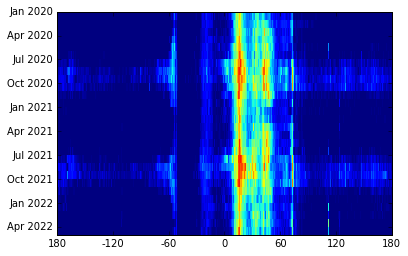

In [37]:
plt.pcolormesh(Nvis,norm=cnorm)
plt.xlim(0,3600)
plt.ylim(28,0)
plt.xticks([0,600,1200,1800,2400,3000,3600],[180,-120,-60,0,60,120,180])
plt.yticks([0,3,6,9,12,15,18,21,24,27],
           ['Jan 2020','Apr 2020',
            'Jul 2020','Oct 2020',
            'Jan 2021','Apr 2021',
            'Jul 2021','Oct 2021',
            'Jan 2022','Apr 2022'])

In [32]:
cnorm2 = colors.LogNorm(vmin=1,vmax=np.amax(timesv))
cmap = plt.get_cmap('viridis').copy()
cmap = cmap.set_under('w')

(0.0, 3600.0)

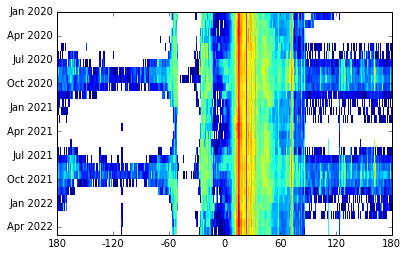

In [36]:
plt.pcolormesh(timesv,cmap=cmap,norm=cnorm2)
plt.ylim(28,0)
plt.xticks([0,600,1200,1800,2400,3000,3600],[180,-120,-60,0,60,120,180])
plt.yticks([0,3,6,9,12,15,18,21,24,27],
           ['Jan 2020','Apr 2020',
            'Jul 2020','Oct 2020',
            'Jan 2021','Apr 2021',
            'Jul 2021','Oct 2021',
            'Jan 2022','Apr 2022'])
plt.xlim(0,3600)

In [38]:
dfout = pd.DataFrame({'ilon':[i for i in range(3600)]})
dfout.head()

,ilon
0,0
1,1
2,2
3,3
4,4


In [39]:
for ix,t in enumerate(utimes):
    dfout[f'{t}_N'] = Nvis[ix]
    dfout[f'{t}_t'] = timesv[ix]
    dfout[f'{t}_A'] = areasv[ix]
dfout.head()

,ilon,2020-01-01T00:00:00.000000000_N,2020-01-01T00:00:00.000000000_t,2020-01-01T00:00:00.000000000_A,2020-02-01T00:00:00.000000000_N,2020-02-01T00:00:00.000000000_t,2020-02-01T00:00:00.000000000_A,2020-03-01T00:00:00.000000000_N,2020-03-01T00:00:00.000000000_t,2020-03-01T00:00:00.000000000_A,...,2022-01-01T00:00:00.000000000_A,2022-02-01T00:00:00.000000000_N,2022-02-01T00:00:00.000000000_t,2022-02-01T00:00:00.000000000_A,2022-03-01T00:00:00.000000000_N,2022-03-01T00:00:00.000000000_t,2022-03-01T00:00:00.000000000_A,2022-04-01T00:00:00.000000000_N,2022-04-01T00:00:00.000000000_t,2022-04-01T00:00:00.000000000_A
0,0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,49.401503,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,1,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,147.610809,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
2,2,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,49.005553,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
3,3,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,97.614709,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
4,4,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,97.218014,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0


In [40]:
dfout.to_csv('./data/routing_tev_Ntimearea_bylon.csv',index=False)